In [1]:
from itertools import islice

import matplotlib.pyplot as plt
plt.rcParams["font.family"] = ["monospace"]
plt.rcParams["pdf.use14corefonts"] = True

import networkx as nx
from networkx.classes.function import path_weight
import numpy as np
from tqdm import tqdm
from scipy.optimize import curve_fit

from networkx.generators import triangular_lattice_graph
import h5py

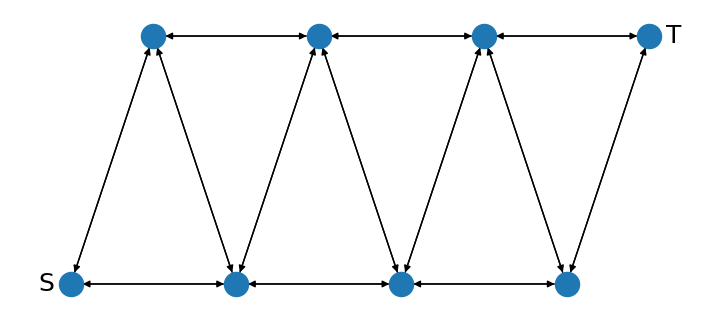

In [2]:
G = triangular_lattice_graph(1, 6)
# G = nx.convert_node_labels_to_integers(G)
G = nx.DiGraph(G)

pos = {node:node for node in G.nodes()}

pos = {
 (0, 0): (0, 0),
 (1, 0): (2, 0),
 (2, 0): (4, 0),
 (3, 0): (6, 0),
 (4, 0): (8, 0),
 (0, 1): (1, 1),
 (1, 1): (3, 1),
 (2, 1): (5, 1),
 (3, 1): (7, 1),
 (4, 1): (9, 1)}

plt.figure(figsize=(7,3))
nx.draw(G, pos)

pos = {
 (0, 0): (-0.3, 0),
 (1, 0): (2, 0),
 (2, 0): (4, 0),
 (3, 0): (6, 0),
 (4, 0): (8, 0),
 (0, 1): (1, 1),
 (1, 1): (3, 1),
 (2, 1): (5, 1),
 (3, 1): (7.3, 1),
}
nx.draw_networkx_labels(G, pos=pos, labels={(0, 0):"S", (3, 1):"T"}, font_size=18);
# plt.savefig("triang2.pdf")

In [3]:
def sp(n, source, target):
    G = triangular_lattice_graph(1, n)
    edges = G.edges()
    
    np.random.seed()
    W = np.random.rand(G.number_of_edges())

    G = nx.DiGraph(G)
    for i, e in enumerate(edges):
        G[e[0]][e[1]]['weight'] = W[i]
        G[e[1]][e[0]]['weight'] = W[i]

    p0, p1 = list(islice(nx.shortest_simple_paths(G, source, target, weight="weight"), 2))
    delta = path_weight(G, p1, weight="weight") - path_weight(G, p0, weight="weight")

    return delta

In [4]:
to_graph = False
if to_graph:
    for n in range(2, 12):
        G = triangular_lattice_graph(1, n)
        
        Ad = nx.adjacency_matrix(G).todense()
        with h5py.File(f"data/triang/adj/adj_n={n}.jld", "w") as hf:
            hf.create_dataset("Ad", data=Ad)

In [5]:
M = 10000
n_max = 11

to_compute = False
if to_compute:
    df = np.zeros((n_max+1-2, 2))
    for n in range(2, n_max+1):
        source = (0, 0)
        if n % 2 == 0:
            target = (n//2, 1)
        else:
            target = (n//2+1, 0)

        dfM = np.zeros(M)
        for m in tqdm(range(M)):
            dfM[m] = sp(n, source, target)
        df[n-2] = (dfM.mean(), dfM.std(ddof=1) / M**0.5)

    np.save("data/triang/deltaF.npy", df)

delta_f = np.load("data/triang/deltaF.npy")
df = np.load("data/triang/triang.npy")

[2.90138114e+00 8.27810134e-01 4.19904930e-17]
[1.84126988 0.27196649 0.05032922]


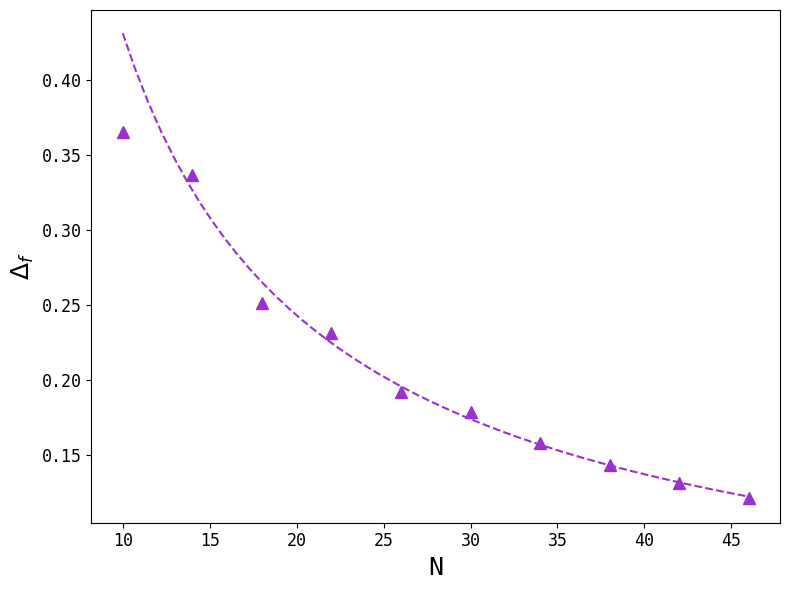

In [7]:
f_fit = lambda x, a, b, c: a / x**b + c

N = np.zeros(n_max-1)
for n in range(2, n_max+1):
    G = triangular_lattice_graph(1, n)
    N[n-2] = G.number_of_edges()*2
x = np.linspace(N[0], max(N))

plt.figure(figsize=(8, 6))
plt.errorbar(N, delta_f[:, 0], yerr=delta_f[:, 1], fmt="^", ms=8, c="darkorchid")
popt, pcov = curve_fit(f_fit, N[4:], delta_f[4:, 0], p0=[0.5, 0.5, 0], sigma=delta_f[4:, 1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)], maxfev=10000)
plt.plot(x, f_fit(x, *popt), label=f"$\\alpha = {popt[1]:.2f} \pm {np.sqrt(pcov[1,1]):.2f}$", c="darkorchid", ls="--")
plt.xlabel("N", fontsize=18)
plt.ylabel("$\Delta_f$", fontsize=18)
# plt.legend(prop={'size': 18})
# plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
plt.savefig("plots/triang_df.pdf", bbox_inches="tight")

print(popt)
print(np.sqrt(np.diag(pcov)))

In [ ]:
f_fit = lambda x, a, b: a / x**b

N = df[:, 0]
x = np.linspace(N[0], max(N))

plt.errorbar(N, df[:, 1], yerr=df[:, 2], fmt=".", ms=7)
popt, pcov = curve_fit(f_fit, N, df[:, 1], sigma=df[:, 2], p0=[0.1, 0.5], maxfev=10000,
                       bounds=([0, 0], [np.inf, np.inf]))

plt.plot(x, f_fit(x, *popt), label=f"$\\alpha = {popt[1]:.3f} \pm {np.sqrt(pcov[1,1]):.3f}$")
plt.xscale("log")
plt.yscale("log")
plt.xlabel("N", fontsize=18)
plt.ylabel("$\Delta_f$", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/triang_df.pdf")

print(popt)
print(np.sqrt(np.diag(pcov)))

In [ ]:
import h5py

n_max = 10
sc = np.zeros((n_max-1, 2))
dmin = np.zeros((n_max-1, 2))
overlap = np.zeros((n_max-1, 2))

for n in range(2, n_max+1):
    f = h5py.File(f"data/triang/n={n}.jld", "r")
    scM, dminM = np.array(f["scM"]), np.array(f["dminM"])
    overlapM = np.array(f["overlapM"])

    scM = scM[(scM != 0) & (overlapM > 0.01)]
    dminM = dminM[(dminM != 0) & (overlapM > 0.01)]
    overlapM = overlapM[(overlapM != 0) & (overlapM > 0.01)]
    M = scM.shape[0]
    print(M)
    
    sc[n-2] = np.mean(scM), np.std(scM, ddof=1) / np.sqrt(M)
    dmin[n-2] = np.mean(dminM), np.std(dminM, ddof=1) / np.sqrt(M)
    overlap[n-2] = np.mean(overlapM), np.std(overlapM, ddof=1) / np.sqrt(M)

In [ ]:
N = np.zeros(n_max+1 - 1)
for n in range(2, n_max+2):
    G = triangular_lattice_graph(1, n)
    N[n-2] = G.number_of_edges()*2

B = 1
A = N.copy()

delta_f = delta_f[:n_max+1, :]

first_order = np.zeros(delta_f.shape)
first_order[:, 0] = 2 * B*delta_f[:, 0] / (B*delta_f[:, 0] + A+2)
first_order[:, 1] = 2*(A+2) / (B*delta_f[:, 0] + A+2)**2 * B*delta_f[:, 1]

In [ ]:
f_fit = lambda x, a, b, c: a / x**b + c

plt.errorbar(N[:n_max-1], dmin[:, 0], yerr=dmin[:, 1], fmt=".", ms=7, label="$\Delta_{min}$")

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N[:n_max-1], dmin[:, 0], sigma=dmin[:, 1], p0=[1, 0.7, 0.15],
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))
print("\n")

x = np.linspace(N[0], N[-1], 1000)
popt, pcov = curve_fit(f_fit, N[2:], first_order[2:, 0], sigma=first_order[2:, 1], p0=[1, 1, 0.1],
                       bounds=([0, 0, 0], [np.inf, np.inf, np.inf]))
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.errorbar(N, first_order[:, 0], yerr=first_order[:, 1], fmt=".", ms=7, label="$\Delta_{min}^{th}$")

plt.xlabel("N", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/triang_dmin.pdf")

In [ ]:
f_fit = lambda x, a, b, c: a / x**b + c

dd = dmin[:, 0] - first_order[:n_max-1, 0]
dd_err = np.sqrt(dmin[:, 1]**2 + first_order[:n_max-1, 1]**2)
plt.errorbar(N[:n_max-1], dd, yerr=dd_err, fmt=".", ms=7, label="$\Delta_{min} - \Delta_{min}^{th}$")

popt, pcov = curve_fit(f_fit, N[:n_max-1], dd, sigma=[1/i**0.5 for i in range(1, n_max)], p0=[0.3, 0.5, 2])#, absolute_sigma=True, maxfev=5000)
x = np.linspace(N[0], N[-1], 1000)
plt.plot(x, f_fit(x, *popt))
print(popt)
print(np.sqrt(np.diag(pcov)))

plt.xlabel("N", fontsize=18)
plt.legend(prop={'size': 18})
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/triang_ddmin.pdf")

In [ ]:
f_fit = lambda x, a, b, c: a / (x**b + c)

plt.errorbar(N[:n_max-1], sc[:, 0], fmt='.', yerr=sc[:, 1], label="$s_c$")
x = np.linspace(N[0], N[-1], 200)
# popt, pcov = curve_fit(f_fit, N[:n_max-1], sc[:, 0], sigma=sc[:, 1], 
#                        p0=[0.1, 1, 0.1], bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
# print(*popt)
# plt.plot(x, f_fit(x, *popt))

sc_first = first_order[:, 0] / delta_f[:, 0]
dsc_first = np.sqrt((first_order[:, 1]/first_order[:, 0])**2 + (delta_f[:, 1]/delta_f[:, 0])**2) * sc_first

popt, pcov = curve_fit(f_fit, N, sc_first, maxfev=10000,
                       sigma=dsc_first, p0=[1, 0.1, 0.1], absolute_sigma=True,
                       bounds=[(0, 0, 0), (np.inf, np.inf, np.inf)])
print(*popt)
print(np.sqrt(np.diag(pcov)))
plt.plot(x, f_fit(x, *popt), c="tab:green")

plt.errorbar(N, sc_first, yerr=dsc_first, fmt='.', label="$s_c^{th}$", c="tab:red")

plt.legend(prop={'size': 18})
plt.xlabel("N", fontsize=18)
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/triang_sc.pdf")

In [ ]:
d_sc = sc[:, 0] - sc_first[:n_max-1]
dd_sc = np.sqrt(sc[:, 1]**2 + dsc_first[:n_max-1]**2)
plt.errorbar(N[:n_max-1], d_sc, yerr=dd_sc, fmt=".-", label="$s_c - s_c^{th}$")
plt.legend(prop={'size': 18})
plt.xlabel("N", fontsize=18)
plt.tight_layout()
plt.grid()

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.tight_layout()
# plt.savefig("plots/triang_dsc.pdf")

In [ ]:
f_fit = lambda x, a, b, c: a / b**x + c

plt.errorbar(N[:n_max-1], overlap[:, 0], fmt='.', yerr=overlap[:, 1])
x = np.linspace(N[0], N[-1], 200)
# popt, pcov = curve_fit(f_fit, N[:n_max-1], overlap[:, 0], sigma=overlap[:, 1], p0=[0.4, 1, 0.5], maxfev=1000)
# print(*popt)
# plt.plot(x, f_fit(x, *popt))

plt.xticks(fontsize=12)
plt.yticks(fontsize=12)

plt.grid()

In [ ]:
np.save(f"data/triang/N.npy", N[:n_max-1])
np.save(f"data/triang/sc.npy", sc)
np.save(f"data/triang/dmin.npy", dmin)
np.save(f"data/triang/ddmin.npy", np.vstack((dd, dd_err)).T)
np.save(f"data/triang/dsc.npy", np.vstack((d_sc, dd_sc)).T)